In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.autograd import Variable
import random

In [5]:
!mkdir models

In [6]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [7]:
batch_size = 64
learning_rate = 3e-3
num_epochs = 30
beta = 1.0
cutmix_prob = 0.5

In [8]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]),
    'test':
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]),
}

In [9]:
data_sets = {
    'train': torchvision.datasets.CIFAR100(root='data', train=True, download=True, transform=data_transforms['train']),
    'test': torchvision.datasets.CIFAR100(root='data', download=True, transform=data_transforms['test'])
}

100%|██████████| 169001437/169001437 [00:02<00:00, 84399040.52it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [10]:
print(data_sets['train'])
print('='*85)
print(data_sets['test'])

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )
Dataset CIFAR100
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )


In [11]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(data_sets['train'],
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=0),
    'test':
    torch.utils.data.DataLoader(data_sets['test'],
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=0)
}

In [12]:
use_cuda = torch.cuda.is_available()

device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


In [13]:
model = models.resnet50(pretrained=True)

model = model.cuda() if use_cuda else model
    
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 1024)
model.fc = nn.Sequential(
    torch.nn.Dropout(0.5),
    torch.nn.Linear(num_ftrs, 1024),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(1024, 512),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(512, 256),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 128),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, len(data_sets['train'].classes))
)

model.fc = model.fc.cuda() if use_cuda else model.fc

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s] 


In [14]:
train_acces, test_acces = [], []
train_losses, test_losses = [], []
total_step = len(dataloaders['train'])
test_loss_min = np.Inf
for epoch in range(num_epochs):
    print(f'Epoch {epoch}\n')

    network_learned = False

    for phase in ['train', 'test']:

        running_loss = 0.0
        running_corrects = 0

        if phase == 'train':
            model.train()

            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):

                if use_cuda:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                    
                r = np.random.rand(1)
                if beta > 0 and r < cutmix_prob:
                    # generate mixed sample
                    lam = np.random.beta(beta, beta)
                    rand_index = torch.randperm(inputs.size()[0]).to(device)
                    target_a = labels
                    target_b = labels[rand_index]
                    bbx1, bby1, bbx2, bby2 = rand_bbox(inputs.size(), lam)
                    inputs[:, :, bbx1:bbx2, bby1:bby2] = inputs[rand_index, :, bbx1:bbx2, bby1:bby2]
                    # adjust lambda to exactly match pixel ratio
                    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (inputs.size()[-1] * inputs.size()[-2]))
                    # compute output
                    inputs = inputs.float()
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, target_a) * lam + criterion(outputs, target_b) * (1. - lam)
                else:
                    # compute output
                    inputs = inputs.float()
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
         
                loss.backward()
                optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)
                if (batch_idx) % 100 == 0:
                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs-1, batch_idx, total_step, loss.item()))
            scheduler.step()
        else:
            with torch.no_grad():
                model.eval()
                for inputs, labels in dataloaders[phase]:
                    if use_cuda:
                        inputs = Variable(inputs.cuda())
                        labels = Variable(labels.cuda())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
                    
                    inputs = inputs.float()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == labels.data)
            network_learned = running_loss < test_loss_min
            test_loss_min = running_loss if network_learned else test_loss_min


        epoch_loss = running_loss / len(data_sets[phase])
        epoch_acc = running_corrects.double() / len(data_sets[phase])
        
        if phase == 'train':
            train_acces.append(epoch_acc * 100)
            train_losses.append(epoch_loss)
        else:
            test_acces.append(epoch_acc * 100)
            test_losses.append(epoch_loss)
    print(f'\ntrain-loss: {np.mean(train_losses):.4f}, train-acc: {train_acces[-1]:.4f}')
    print(f'test loss: {np.mean(test_losses):.4f}, test acc: {test_acces[-1]:.4f}\n')

    if network_learned:
        torch.save(model.state_dict(), 'models/weights.h5')
        print('Improvement-Detected, save-model')

Epoch 0

Epoch [0/29], Step [0/782], Loss: 4.6173
Epoch [0/29], Step [100/782], Loss: 4.5652
Epoch [0/29], Step [200/782], Loss: 4.5825
Epoch [0/29], Step [300/782], Loss: 4.4572
Epoch [0/29], Step [400/782], Loss: 3.8649
Epoch [0/29], Step [500/782], Loss: 3.6981
Epoch [0/29], Step [600/782], Loss: 3.3666
Epoch [0/29], Step [700/782], Loss: 3.9507

train-loss: 0.0635, train-acc: 8.7940
test loss: 0.0423, test acc: 30.9880

Improvement-Detected, save-model
Epoch 1

Epoch [1/29], Step [0/782], Loss: 3.0231
Epoch [1/29], Step [100/782], Loss: 3.2772
Epoch [1/29], Step [200/782], Loss: 3.1663
Epoch [1/29], Step [300/782], Loss: 3.4309
Epoch [1/29], Step [400/782], Loss: 2.2500
Epoch [1/29], Step [500/782], Loss: 3.9354
Epoch [1/29], Step [600/782], Loss: 2.8059
Epoch [1/29], Step [700/782], Loss: 3.5823

train-loss: 0.0564, train-acc: 26.3960
test loss: 0.0373, test acc: 46.5800

Improvement-Detected, save-model
Epoch 2

Epoch [2/29], Step [0/782], Loss: 2.1188
Epoch [2/29], Step [100/782

In [37]:
torch.save(model.state_dict(), 'resnet18_cifar100_cutmix.pth')

In [34]:
train_acces_list = [acc.item() for acc in train_acces]
test_acces_list = [acc.item() for acc in test_acces]

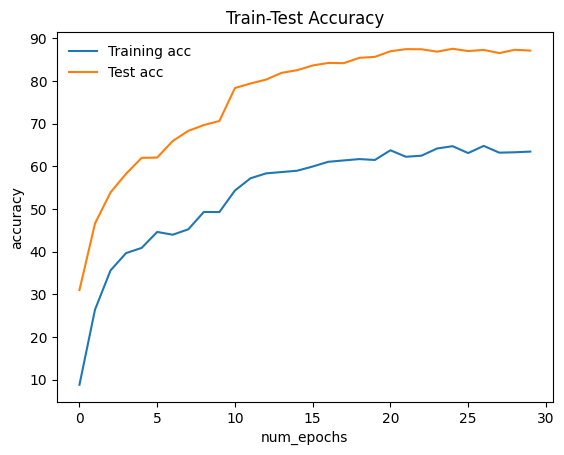

In [35]:
plt.title("Train-Test Accuracy")
plt.plot(train_acces_list, label='Training acc')
plt.plot(test_acces_list, label='Test acc')
plt.xlabel('num_epochs')
plt.ylabel('accuracy')
plt.legend(frameon=False)
plt.show()

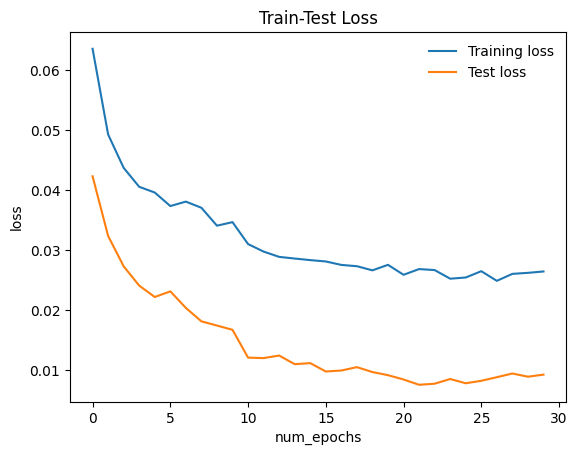

In [36]:
plt.title("Train-Test Loss")
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('num_epochs')
plt.ylabel('loss')
plt.legend(frameon=False)
plt.show()